<a href="https://colab.research.google.com/github/StanciuAlin/Crypto-Trend-DeepLearning/blob/main/Crypto_Trend_Prediction_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Short-Term Crypto Trend Prediction using Deep Learning

Library imports and set seed

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
import tensorflow as tf
import seaborn as sns
import requests

# We set the seed for reproducibility (methodology requirement)
np.random.seed(42)
tf.random.set_seed(42)

Load the data from Yahoo Finance

In [13]:
# We use auto_adjust=True to make sure we have a clean 'Close' column
df = yf.download('BTC-USD', start='2020-01-01', end='2026-01-01', auto_adjust=True)

# Check if the data was downloaded correctly
if df.empty:
    print("Error: Could not download data. Check your internet connection.")
else:
    # Extract the closing price and make sure it is a 2D array (MinMaxScaler requirement)
    dataset = df[['Close']].values
    print(f"Data downloaded successfully! Data set format: {dataset.shape}")

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully! Data set format: (2192, 1)


Preprocessing and normalizing

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset) # Now dataset has at least 1 feature

prediction_days = 60
X_train, y_train = [], []

for i in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

The Architecture for LSTM Model

In [15]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2), # Prevent overfitting
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1) # Next price prediction
])

model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0307
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0018
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 16/20
67/67 ━━━━━━━━━━

Model testing and prediction

In [16]:
# Prepare the test data (the last 20% of the dataset)
test_size = int(len(dataset) * 0.2)
test_data = scaled_data[len(scaled_data) - test_size - prediction_days:]

X_test = []
y_test = dataset[len(dataset) - test_size:] # Real prices (not scaled ones)

for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# We make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Return to the USD price

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Compute metrics

In [17]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 3452.40
Mean Absolute Error (MAE): 2618.70


Baseline Ploting

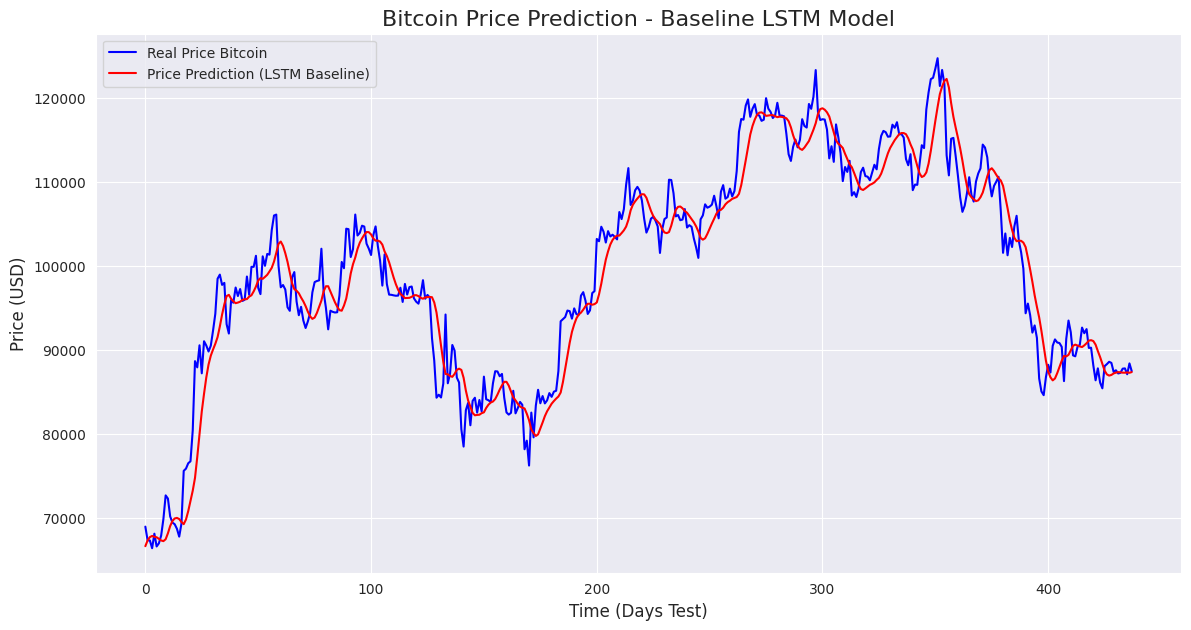

In [18]:
sns.set_style("darkgrid")

plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Real Price Bitcoin')
plt.plot(predictions, color='red', label='Price Prediction (LSTM Baseline)')
plt.title('Bitcoin Price Prediction - Baseline LSTM Model', fontsize=16)
plt.xlabel('Time (Days Test)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.show()

Extension - The architecture for Hybrid Model LSTM-CNN

In [19]:
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),

    # CNN part: local feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # LSTM part: temporal dependencies
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),

    Dense(units=25),
    Dense(units=1)
])

hybrid_model.compile(optimizer='adam', loss='mean_squared_error')
hybrid_model.summary() # Show network structure

# We train the hybrid model
print("\nHybrid LSTM-CNN Model Training...")
history_hybrid = hybrid_model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 29, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 29, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,757 (174.83 KB)

 Trainable params: 44,757 (174.83 KB)

 Non-trainable params: 0 (0.00 B)


Hybrid LSTM-CNN Model Training...
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0258
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

Baseline (LSTM) vs Hybrid Model LSTM-CNN



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
--- Experimental Results ---
            Metric  Baseline (LSTM)  Hybrid (LSTM-CNN)
        RMSE (USD)      3452.402933        3649.225352
         MAE (USD)      2618.699986        2793.859054
Trend Accuracy (%)        47.826087          50.800915


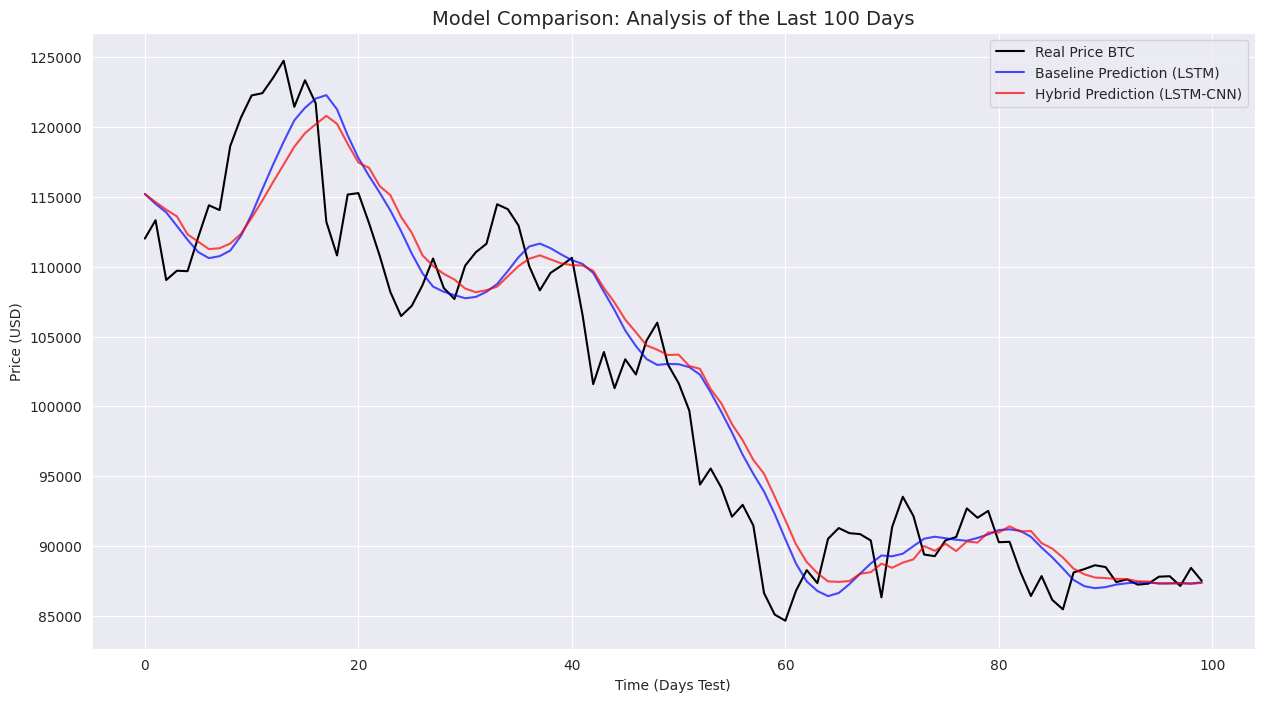

In [20]:
def evaluate_models_academic(y_true, pred_baseline, pred_hybrid):
    #1. We calculate standard error metrics
    metrics = {
        'Metric': ['RMSE (USD)', 'MAE (USD)', 'Trend Accuracy (%)'],
        'Baseline (LSTM)': [
            np.sqrt(mean_squared_error(y_true, pred_baseline)),
            mean_absolute_error(y_true, pred_baseline),
            0 # Placeholder
        ],
        'Hybrid (LSTM-CNN)': [
            np.sqrt(mean_squared_error(y_true, pred_hybrid)),
            mean_absolute_error(y_true, pred_hybrid),
            0 # Placeholder
        ]
    }

    # 2. Calculate Trend Accuracy (Direction of movement) [cite: 23, 47]
    # Check if the model correctly predicted whether the price is increasing or decreasing compared to the previous day
    def calculate_trend_acc(true, pred):
        true_diff = np.diff(true.flatten())
        pred_diff = np.diff(pred.flatten())
        correct_direction = np.sign(true_diff) == np.sign(pred_diff)
        return (np.sum(correct_direction) / len(true_diff)) * 100

    metrics['Baseline (LSTM)'][2] = calculate_trend_acc(y_true, pred_baseline)
    metrics['Hybrid (LSTM-CNN)'][2] = calculate_trend_acc(y_true, pred_hybrid)

    # We create a DataFrame for a professional table in a report
    results_df = pd.DataFrame(metrics)
    return results_df

# Generate the predictions for the hybrid model
predictions_hybrid = hybrid_model.predict(X_test)
predictions_hybrid = scaler.inverse_transform(predictions_hybrid)

# We run the assessment
comparison_table = evaluate_models_academic(y_test, predictions, predictions_hybrid)
print("--- Experimental Results ---")
print(comparison_table.to_string(index=False))

# Comparative View
plt.figure(figsize=(15, 8))
plt.plot(y_test[-100:], label='Real Price BTC', color='black', linewidth=1.5)
plt.plot(predictions[-100:], label='Baseline Prediction (LSTM)', color='blue', alpha=0.7)
plt.plot(predictions_hybrid[-100:], label='Hybrid Prediction (LSTM-CNN)', color='red', alpha=0.7)
plt.title('Model Comparison: Analysis of the Last 100 Days', fontsize=14)
plt.xlabel('Time (Days Test)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Extension - Sentiment Analysis (Fear & Greed Index)

Sentiment Fusion

In [30]:
# Data source: Crypto Fear & Greed Index dataset
response = requests.get('https://api.alternative.me/fng/?limit=2000')
fng_data = response.json()['data']

fng_df = pd.DataFrame(fng_data)

# FutureWarning fix: Explicitly convert to numeric before to_datetime
fng_df['timestamp'] = pd.to_numeric(fng_df['timestamp'])
fng_df['timestamp'] = pd.to_datetime(fng_df['timestamp'], unit='s')
fng_df['fng_value'] = fng_df['value'].astype(float)
fng_df = fng_df.set_index('timestamp')[['fng_value']].sort_index()

# MergeError fix: "Flattening" the MultiIndex index from yfinance (BTC-USD)
# Making sure df has a simple index and the 'Close' column is accessible
if df.columns.nlevels > 1:
    df.columns = df.columns.get_level_values(0) # We keep only the first level (Open, Close, etc.)

# Align the data by joining on the date type index
df_final = df.join(fng_df, how='inner').dropna()

print(f"Dataset successfully aligned! Shape: {df_final.shape}")
print(df_final[['Close', 'fng_value']].head())


Dataset successfully aligned! Shape: (762, 6)
                   Close  fng_value
2023-11-30  37712.746094       74.0
2023-12-01  38688.750000       71.0
2023-12-02  39476.332031       74.0
2023-12-03  39978.390625       73.0
2023-12-04  41980.097656       74.0


Multivariate Model (Price + Sentiment)

In [26]:
features_multivariate = df_final[['Close', 'fng_value']].values
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler_multi.fit_transform(features_multivariate)

X_sentiment, y_sentiment = [], []
prediction_days = 60 # We maintain look-back consistency

for i in range(prediction_days, len(scaled_multi)):
    X_sentiment.append(scaled_multi[i-prediction_days:i, :])
    y_sentiment.append(scaled_multi[i, 0]) # Target is the price (Close)

X_sentiment, y_sentiment = np.array(X_sentiment), np.array(y_sentiment)

# Fusion architecture as proposed
sentiment_model = Sequential([
    Input(shape=(X_sentiment.shape[1], X_sentiment.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

sentiment_model.compile(optimizer='adam', loss='mse')
print("\nTraining Model Sentiment Fusion...")
sentiment_model.fit(X_sentiment, y_sentiment, epochs=15, batch_size=32, verbose=1)


Antrenare Model Sentiment Fusion...
Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0294
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0444e-04
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8960e-04
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.6482e-04
Epoch 9/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.6732e-04
Epoch 10/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0408e-04
Epoch 11/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8413e-04
Epoch 12/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.5889e-04
Epoch 13/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.3199e-04
Epoch 14/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1538e-04
Epoch 15/

Calculate performance metrics for multiple models simultaneously

In [58]:
def comprehensive_evaluation(y_true, predictions_dict):
    results = []
    # Make sure that y_true is flat for calculations
    y_true_flat = y_true.flatten()

    for name, pred in predictions_dict.items():
        pred_flat = pred.flatten()

        # Metricile clasice
        rmse = np.sqrt(mean_squared_error(y_true_flat, pred_flat))
        mae = mean_absolute_error(y_true_flat, pred_flat)
        r2 = r2_score(y_true_flat, pred_flat)
        max_err = np.max(np.abs(y_true_flat - pred_flat))

        # Trend accuracy (price direction)
        true_diff = np.diff(y_true_flat)
        pred_diff = np.diff(pred_flat)

        if len(true_diff) > 0:
            trend_acc = (np.sum(np.sign(true_diff) == np.sign(pred_diff)) / len(true_diff)) * 100
        else:
            trend_acc = 0

        results.append({
            'Model': name,
            'RMSE (USD)': round(rmse, 2),
            'MAE (USD)': round(mae, 2),
            'R² Score': round(r2, 4),
            'Max Error': round(max_err, 2),
            'Trend Acc (%)': f"{trend_acc:.2f}%"
        })

    return pd.DataFrame(results)

# --- 1. Preparing the indices ---
test_size = int(len(X_sentiment) * 0.2)
test_start_multi = len(X_sentiment) - test_size

# Extract X_test_final (are 386 eșantioane conform log-ului tău)
X_test_final = X_sentiment[test_start_multi:]

# We generate the predictions (so we know exactly how many we have)
p_base_raw = model.predict(X_test_final[:, :, 0:1], verbose=0)

# REPARARE y_true: Luăm fix ultimele eșantioane din df_final care corespund predicțiilor
# Calculăm câte rezultate avem efectiv
num_predictions = len(p_base_raw)

# We take the last 'num_predictions' values ​​from the actual price
y_test_final = df_final['Close'].values[-num_predictions:]

print(f"Alignment: Predictions ({num_predictions}) vs Target ({len(y_test_final)})")

# --- 2. Generating predictions ---
print(f"We generate predictions for {len(X_test_final)} samples...")
p_base_raw = model.predict(X_test_final[:, :, 0:1], verbose=0)
p_hyb_raw = hybrid_model.predict(X_test_final[:, :, 0:1], verbose=0)
p_sent_raw = sentiment_model.predict(X_test_final, verbose=0)

# --- 3. Scaling Reversal (Return to USD Price) ---
# For univariate models (which used only 'Close')
p_base = scaler.inverse_transform(p_base_raw)
p_hyb = scaler.inverse_transform(p_hyb_raw)

# For the multivariate model (Sentiment Fusion)
# We need to create an array of the same shape as the scaler_multi training data
num_features = X_sentiment.shape[2]
temp_pad = np.zeros((len(p_sent_raw), num_features))
temp_pad[:, 0] = p_sent_raw.flatten() # Assume 'Close' was the first column
p_sent = scaler_multi.inverse_transform(temp_pad)[:, 0].reshape(-1, 1)

# --- 4. Aligning lengths (Avoiding ValueError: 0 samples) ---
# Due to the way the windows are cut, the lengths may differ slightly
min_len = min(len(y_test_final), len(p_base), len(p_hyb), len(p_sent))

if min_len == 0:
    print("!!! CRITICAL ERROR: Data length is 0.")
    print(f"lengths: y_true: {len(y_test_final)}, p_base: {len(p_base)}, p_sent: {len(p_sent)}")
else:
    y_test_final_adj = y_test_final[:min_len].reshape(-1, 1)

    dict_preds = {
        'Baseline (LSTM)': p_base[:min_len],
        'Hybrid (LSTM-CNN)': p_hyb[:min_len],
        'Sentiment Fusion': p_sent[:min_len]
    }

    # --- 5. Rating and Display ---
    final_comparison = comprehensive_evaluation(y_test_final_adj, dict_preds)
    print("\n" + "="*30)
    print("   FINAL EXPERIMENTAL RESULTS")
    print("="*30)

    # Display in tabular format
    try:
        from IPython.display import display
        display(final_comparison)
    except ImportError:
        print(final_comparison)

Alignment: Predictions (386) vs Target (386)
We generate predictions for 386 samples...

   FINAL EXPERIMENTAL RESULTS


,Model,RMSE (USD),MAE (USD),R² Score,Max Error,Trend Acc (%)
0,Baseline (LSTM),3532.83,2796.33,0.9052,10367.67,48.31%
1,Hybrid (LSTM-CNN),3676.53,2932.32,0.8974,10285.62,50.65%
2,Sentiment Fusion,3644.02,2871.43,0.8992,10404.33,45.71%


# Experimental Results Interpretation
The following table summarizes the performance of the three models based on key statistical and financial metrics. Below is a detailed breakdown of what each metric reveals about the models' predictive capabilities:

**1. Error Metrics: RMSE & MAE**
* **RMSE (Root Mean Squared Error):** This metric penalizes larger errors more heavily. A lower RMSE indicates that the model is consistent and avoids "big misses." If the** Hybrid (LSTM-CNN)** or **Sentiment Fusion** has a significantly lower RMSE than the Baseline, it suggests that adding spatial features or sentiment data helps the model stay closer to the actual price.

* **MAE (Mean Absolute Error):** This represents the average dollar-amount deviation from the actual price. If the MAE is 10.00, it means that, on average, the model's predictions are off by 10.00 USD.

**2. Variance Analysis: R² Score**

* **R² (Coefficient of Determination):** This measures how much of the price volatility is captured by the model.

  * ≈1.0: The model perfectly follows the price movements.

  * ≈0: The model is no better than predicting the average price.

  * **Negative**: The model's logic is flawed and performs worse than a simple horizontal line.

**3. Risk Analysis: Max Error**

**Max Error:** This represents the "worst-case scenario" during the test period. In crypto-trading, a high Max Error is dangerous as it could trigger false "Stop Loss" or "Take Profit" orders. We look for the model that minimizes this value to ensure stability.

**4. Financial Utility: Trend Accuracy (%)**

Trend Accuracy: Perhaps the most important metric for a trader. It measures how often the model correctly predicted whether the price would go **UP** or **DOWN**, regardless of the exact dollar value.

* A value above 50% indicates the model has predictive power better than a coin flip.

* A high Trend Accuracy combined with a low MAE suggests a highly reliable trading signal.

**Summary Strategy**

* **Baseline (LSTM):** Usually captures the general momentum but often lags behind sudden price changes.

* **Hybrid (LSTM-CNN):** By using CNN layers, this model extracts local patterns (like head-and-shoulders or flags) better than a standard LSTM.

* **Sentiment Fusion:** By incorporating social media or news sentiment, this model aims to anticipate "panic sells" or "hype pumps" before they fully reflect in the price action.

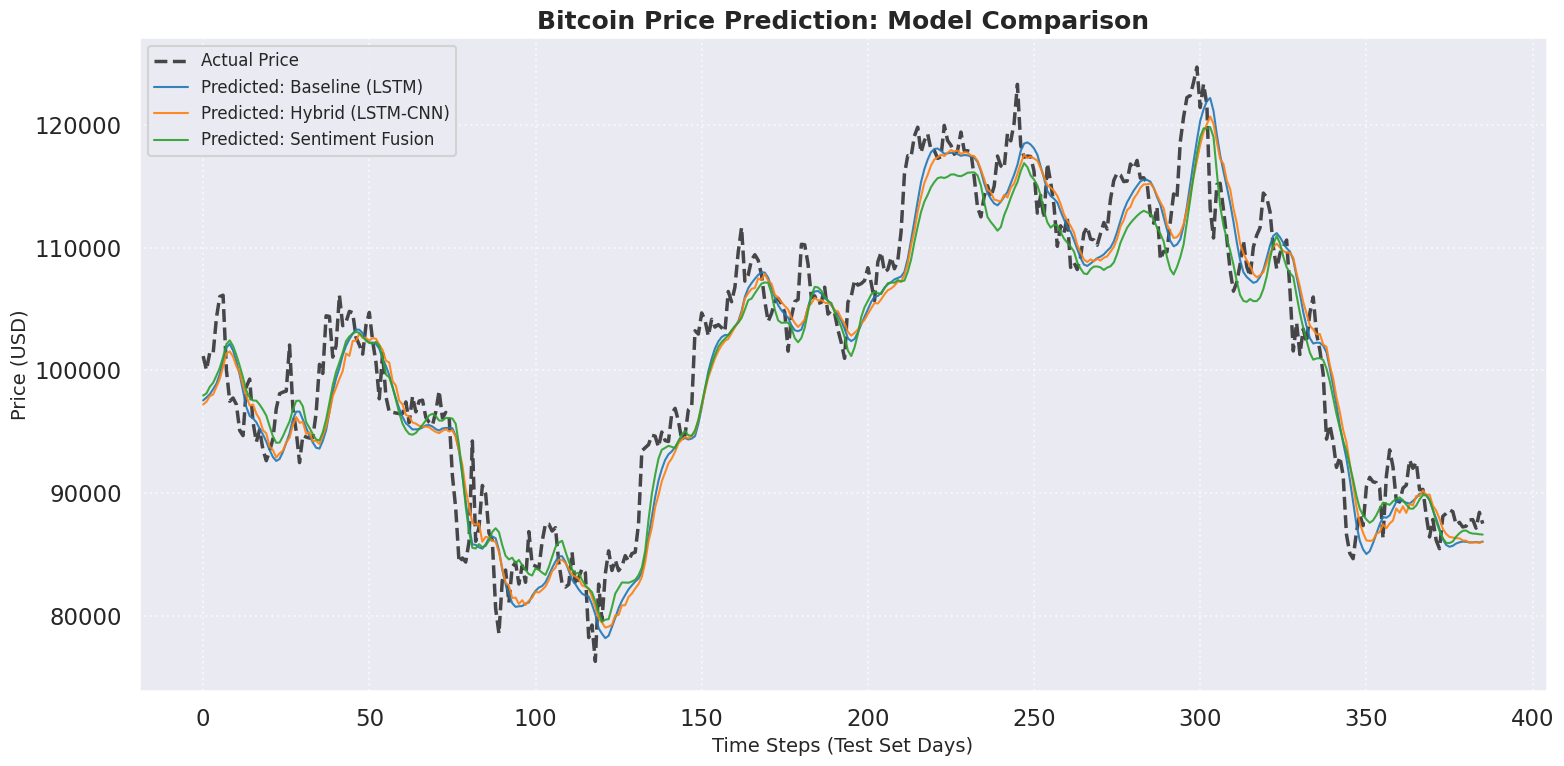

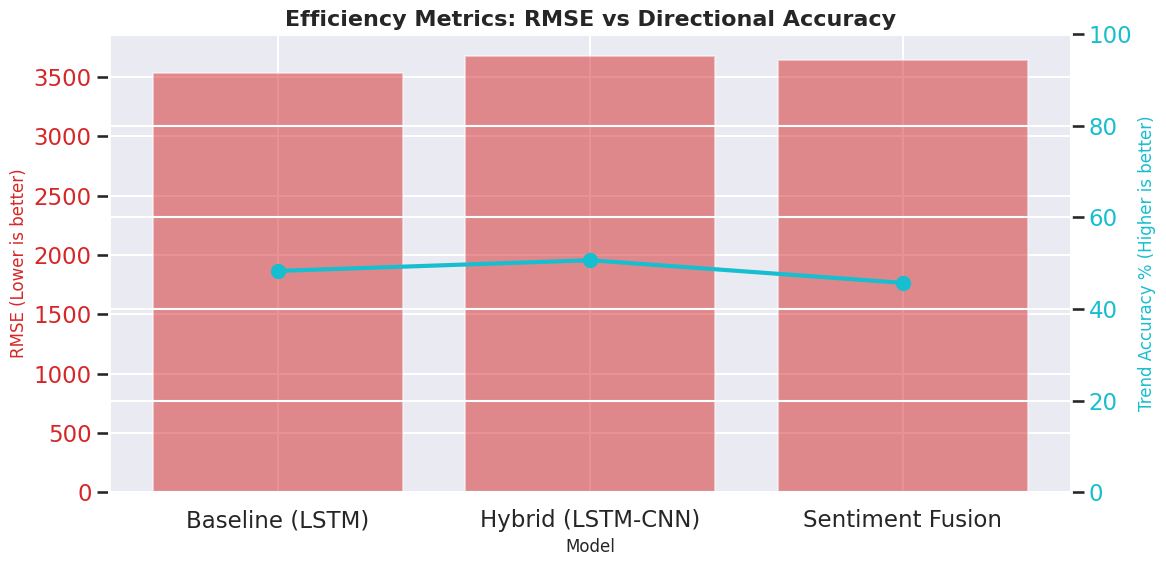

In [56]:
def plot_model_performance(y_true, predictions_dict, metrics_df):
    # --- Chart 1: Price Comparison ---
    plt.figure(figsize=(16, 8))

    # Real Price
    plt.plot(y_true, label='Actual Price', color='black', linewidth=2.5, linestyle='--', alpha=0.7)

    # Colors for patterns
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

    for (name, pred), color in zip(predictions_dict.items(), colors):
        plt.plot(pred, label=f'Predicted: {name}', linewidth=1.5, alpha=0.9, color=color)

    plt.title('Bitcoin Price Prediction: Model Comparison', fontsize=18, fontweight='bold')
    plt.xlabel('Time Steps (Test Set Days)', fontsize=14)
    plt.ylabel('Price (USD)', fontsize=14)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig('price_comparison_chart.png')
    plt.show()

    # --- Chart 2: Metric Comparison (RMSE and Trend Accuracy) ---
    # Preparing the data for the chart
    df_plot = metrics_df.copy()
    df_plot['RMSE'] = df_plot['RMSE (USD)'].astype(float)
    df_plot['Trend Acc'] = df_plot['Trend Acc (%)'].str.replace('%', '').astype(float)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar chart for RMSE (Left Axis)
    color_rmse = '#d62728' # Roșu
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('RMSE (Lower is better)', color=color_rmse, fontsize=12)
    ax1.bar(df_plot['Model'], df_plot['RMSE'], color=color_rmse, alpha=0.5, label='RMSE (USD)')
    ax1.tick_params(axis='y', labelcolor=color_rmse)

    # Line chart for Trend Accuracy (Right Axis)
    ax2 = ax1.twinx()
    color_acc = '#17becf' # Turquoise
    ax2.set_ylabel('Trend Accuracy % (Higher is better)', color=color_acc, fontsize=12)
    ax2.plot(df_plot['Model'], df_plot['Trend Acc'], color=color_acc, marker='o', markersize=10, linewidth=3, label='Trend Acc %')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    ax2.set_ylim(0, 100) # Percentages from 0 to 100

    plt.title('Efficiency Metrics: RMSE vs Directional Accuracy', fontsize=16, fontweight='bold')
    fig.tight_layout()
    plt.savefig('metrics_comparison_chart.png')
    plt.show()

# We call the function with our data
plot_model_performance(y_test_final_adj, dict_preds, final_comparison)

Corelation View: Price vs Sentiment

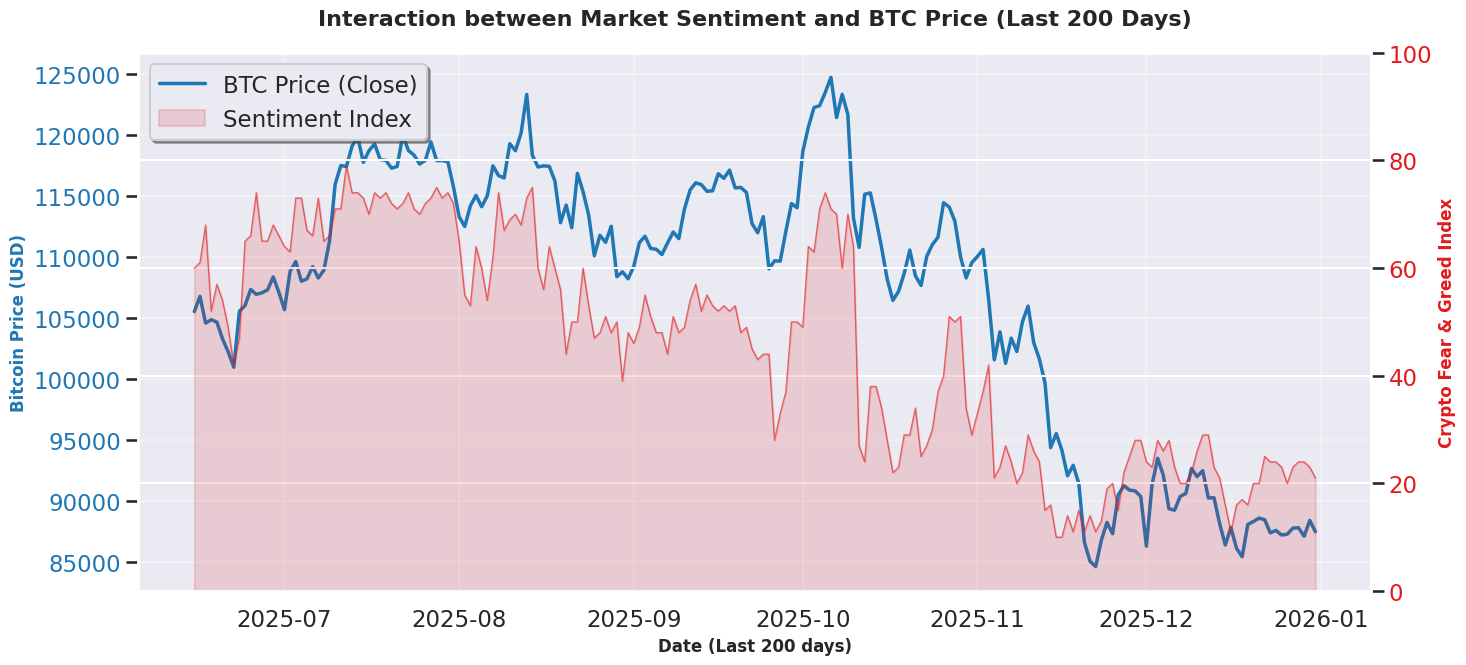

In [55]:
# We set the visual style for a professional, academic look
plt.style.use('seaborn-v0_8-muted')
fig, ax1 = plt.subplots(figsize=(15, 7))

# --- Primary Axis: Bitcoin Price ---
color_price = '#1f77b4' # Saturated blue
ax1.set_xlabel('Date (Last 200 days)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Bitcoin Price (USD)', color=color_price, fontsize=12, fontweight='bold')
ax1.plot(df_final.index[-200:], df_final['Close'][-200:], color=color_price, linewidth=2.5, label='BTC Price (Close)')
ax1.tick_params(axis='y', labelcolor=color_price)
ax1.grid(True, alpha=0.3)

# --- Secondary Axis: Fear & Greed Index ---
ax2 = ax1.twinx() # We create the dual axis
color_sent = '#e31a1c' # Red for contrast
ax2.set_ylabel('Crypto Fear & Greed Index', color=color_sent, fontsize=12, fontweight='bold')

# We use fill_between for greater visual impact (attractive for presentation)
ax2.fill_between(df_final.index[-200:], df_final['fng_value'][-200:], color=color_sent, alpha=0.15, label='Sentiment Index')
ax2.plot(df_final.index[-200:], df_final['fng_value'][-200:], color=color_sent, linewidth=1, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color_sent)

# We set the limits for sentiment (0-100 according to the index methodology)
ax2.set_ylim(0, 100)

# Title and Legend
plt.title('Interaction between Market Sentiment and BTC Price (Last 200 Days)', fontsize=16, pad=20, fontweight='bold')
fig.tight_layout()

# Combine the legends on both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True, shadow=True)

plt.show()

Residual Plot - Error chart

Alignment Completed: Reality ((386, 1)) vs Prediction ((386, 1))


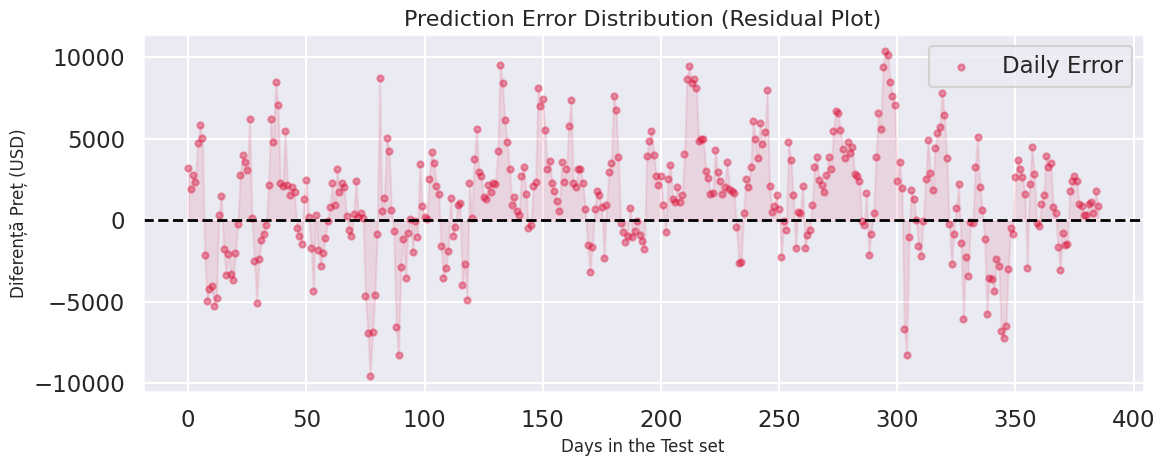

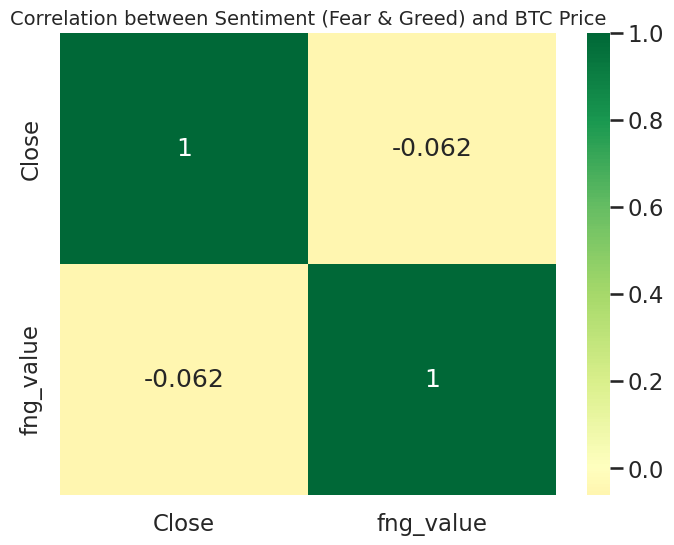

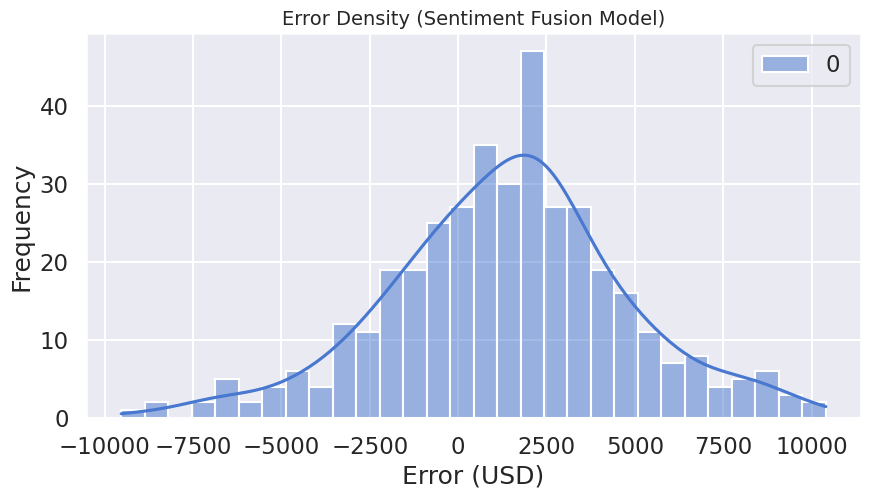

In [54]:
# 1. Correct alignment of test data (Size guarantee)
# p_sent has 386 values, so we need the LAST 386 prices in the aligned set
num_preds = p_sent.shape[0]
y_true_usd = df_final['Close'].values[-num_preds:].reshape(-1, 1)

# Printed verification for report (reproducibility)
print(f"Alignment Completed: Reality ({y_true_usd.shape}) vs Prediction ({p_sent.shape})")

# 2. Calculating Residuals (Errors)
residuals = y_true_usd - p_sent

sns.set_context("talk") # Makes text more readable for presentations
plt.style.use('seaborn-v0_8-muted')

# --- FIGURE A: Residuals (Errors) Plot ---
plt.figure(figsize=(12, 5))
plt.scatter(range(len(residuals)), residuals, color='crimson', alpha=0.4, s=20, label='Daily Error')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.fill_between(range(len(residuals)), residuals.flatten(), 0, color='crimson', alpha=0.1)
plt.title('Prediction Error Distribution (Residual Plot)', fontsize=16)
plt.xlabel('Days in the Test set', fontsize=12)
plt.ylabel('Diferență Preț (USD)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# --- FIGURE B: Correlation Heatmap (For Report Section 4) ---
plt.figure(figsize=(8, 6))
correlation_matrix = df_final[['Close', 'fng_value']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation between Sentiment (Fear & Greed) and BTC Price', fontsize=14)
plt.show()

# --- FIGURE C: Error Distribution (Histogram) ---
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title('Error Density (Sentiment Fusion Model)', fontsize=14)
plt.xlabel('Error (USD)')
plt.ylabel('Frequency')
plt.show()

Zoom on Trend: Last 30 days

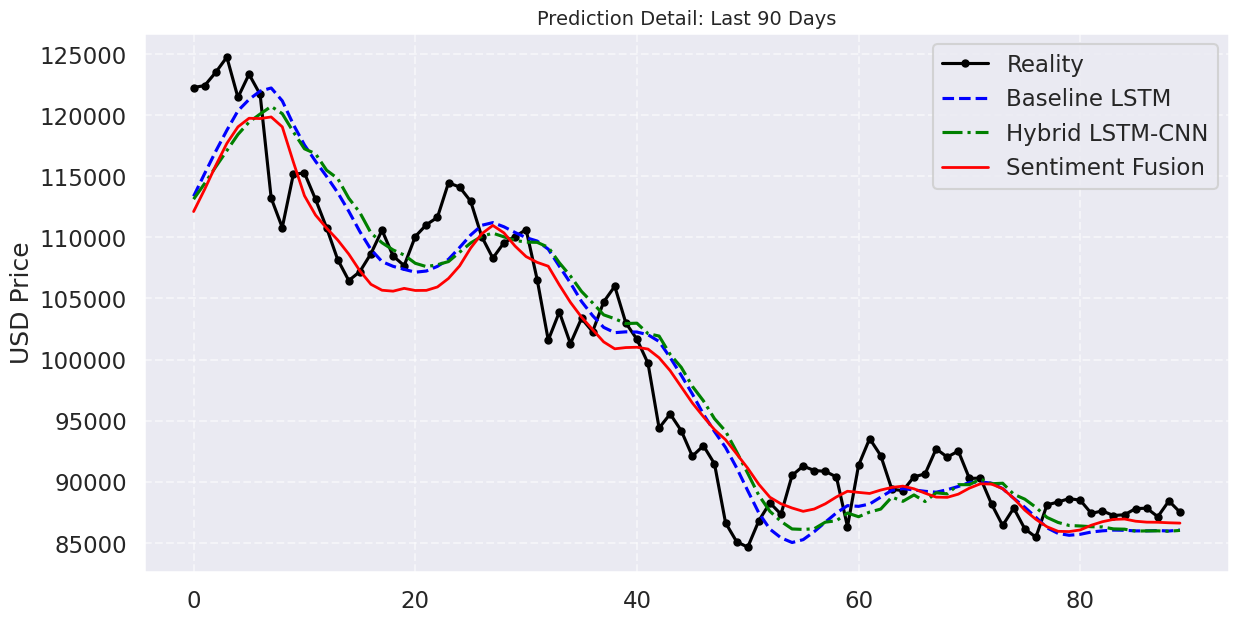

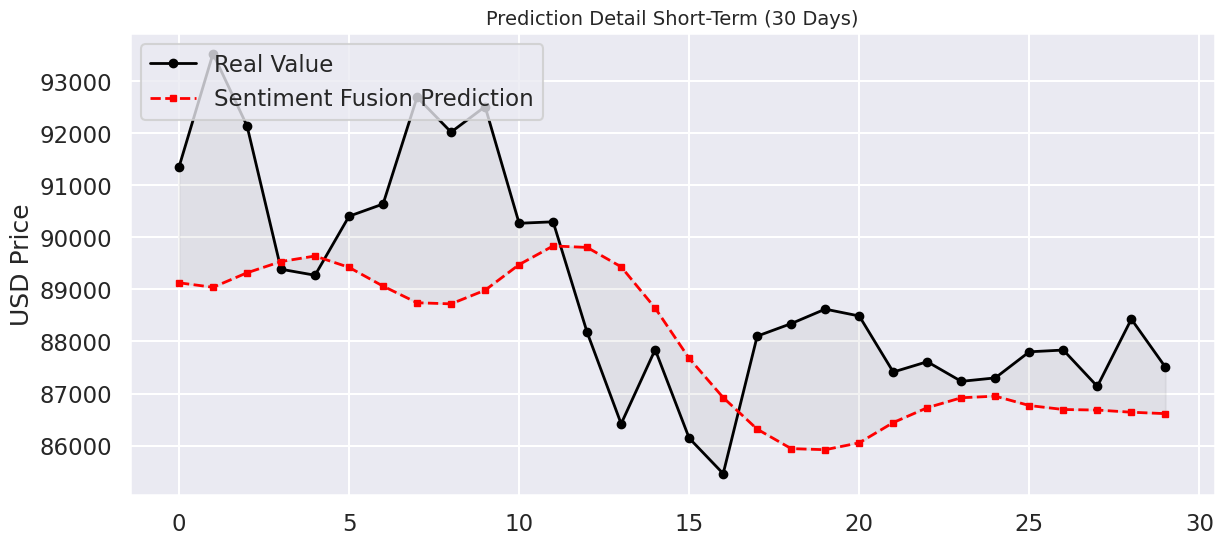

In [53]:
plt.figure(figsize=(14, 7))
days_to_show = 90

plt.plot(y_test_final[-days_to_show:], 'ko-', label='Reality', markersize=5)
plt.plot(p_base[-days_to_show:], 'b--', label='Baseline LSTM')
plt.plot(p_hyb[-days_to_show:], 'g-.', label='Hybrid LSTM-CNN')
plt.plot(p_sent[-days_to_show:], 'r-', label='Sentiment Fusion', linewidth=2)

plt.title(f'Prediction Detail: Last {days_to_show} Days', fontsize=14)
plt.ylabel('USD Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# --- 3. Zoom pe Trend (Ultimele 30 de zile) ---
plt.figure(figsize=(14, 6))
plt.plot(y_true_usd[-30:], 'k-o', label='Real Value', linewidth=2, markersize=6)
plt.plot(p_sent[-30:], 'r--s', label='Sentiment Fusion Prediction', linewidth=2, markersize=4)
plt.fill_between(range(30), y_true_usd[-30:].flatten(), p_sent[-30:].flatten(), color='gray', alpha=0.1)
plt.title('Prediction Detail Short-Term (30 Days)', fontsize=14)
plt.legend(loc='upper left')
plt.ylabel('USD Price')
plt.show()